https://python.langchain.com/docs/tutorials/rag/

## Loading Environent Variables

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# os.getenv('LANGSMITH_API_KEY')
# os.getenv('OPENAI_API_KEY')
# os.getenv('PINECONE_API_KEY')
# os.getenv('PINECONE_INDEX_NAME')

True

## Selecting Chat Model

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

# Selecting Embeddings Model

In [3]:
from langchain_openai import OpenAIEmbeddings

# OpenAI Embedding Models and their dimensions:
# - text-embedding-ada-002: 1536 dimensions
# - text-embedding-3-small: 1536 dimensions  
# - text-embedding-3-large: 3072 dimensions
# - text-embedding-3-small with dimensions=1024: 1024 dimensions

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    dimensions=1024  
)

## Selecting Vector Store

In [4]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

pc = Pinecone(api_key=os.getenv('PINECONE_API_KEY'))
index = pc.Index(os.getenv('PINECONE_INDEX_NAME'))

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

c:\Users\PX\anaconda3\envs\music-chatbot\lib\site-packages\langchain_pinecone\__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore
Index host ignored when initializing with index object.


## LOADING THE DOCUMENT

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


## SPLITTING THE DOCUMENT

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

## STORING PERMANENTLY THE SPLITS INTO THE PINCONE VECTOR DB

In [7]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)
print(index.describe_index_stats())

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 126}},
 'total_vector_count': 126,
 'vector_type': 'dense'}


## Downloading a ready-made RAG question-answering prompt template from LangChain Hub and making it available as a PromptTemplate object in prompt

In [8]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


### RETRIEVING DOCS BASED ON THE QUESTION 
### GENERATING ANSWER BASED ON THE RETRIEVED DOCS (CONTEXT) 

In [ ]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

## BUILDING THE LANGGRAPH

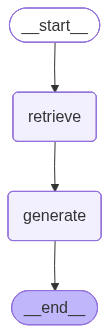

In [18]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
graph

## TESTING THE APP

In [11]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into simpler, manageable steps or subgoals. This can be achieved through methods like simple prompts, task-specific instructions, or human inputs. Additionally, approaches like Chain of Thought (CoT) and Tree of Thoughts enhance this by guiding structured reasoning through multiple steps.
